# 04a: Exact Symmetries and Orbit Sizes

**Goal**: Test Z2 symmetries and measure orbit sizes for compression.

**Symmetries to test**:
1. Team reflection (Z2): swap teams 0↔1, negate V
2. Seat rotation (Z2): rotate by 2 seats, preserve V

**Combined**: Klein four-group (Z2 × Z2), max 4 elements per orbit.

**Success Metric**: Compression ratio > 2x

**Reference**: docs/analysis-draft.md Section 2

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz, symmetry
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Sample Data

In [2]:
# Load multiple seeds
shard_files = loading.find_shard_files(DATA_DIR)
N_SEEDS = min(10, len(shard_files))
sample_files = shard_files[:N_SEEDS]
print(f"Analyzing {N_SEEDS} shards")

Analyzing 10 shards


In [3]:
# Load shards
SAMPLE_PER_SHARD = 50_000

dfs = []
for path in tqdm(sample_files, desc="Loading shards"):
    df, seed, decl_id = schema.load_file(path)
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=seed)
    df['seed'] = seed
    df['decl_id'] = decl_id
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(combined_df):,} states from {N_SEEDS} shards")

Loading shards:   0%|          | 0/10 [00:00<?, ?it/s]

Loaded 500,000 states from 10 shards


In [4]:
# Extract arrays
states = combined_df['state'].values
V = combined_df['V'].values

# Get trick_len to filter
_, _, trick_len, _, _, _ = schema.unpack_state(states)
print(f"Trick length distribution:")
print(pd.Series(trick_len).value_counts().sort_index())

Trick length distribution:
0     23711
1     65958
2    135064
3    275267
Name: count, dtype: int64


## 2. Test Team Swap Symmetry

Team swap: Players 0↔1, 2↔3

Effect: V → -V

In [5]:
# Filter to trick_len=0 for clean symmetry transformation
clean_mask = trick_len == 0
clean_states = states[clean_mask]
clean_V = V[clean_mask]
print(f"States with trick_len=0: {len(clean_states):,} ({100*len(clean_states)/len(states):.1f}%)")

States with trick_len=0: 23,711 (4.7%)


In [6]:
# Apply team swap
swapped_states = symmetry.team_swap(clean_states)

# Build lookup for V
state_to_v = dict(zip(clean_states, clean_V))

# Check V consistency for swapped states
swap_consistent = 0
swap_total = 0
v_diffs = []

for i in range(len(clean_states)):
    orig_state = int(clean_states[i])
    swap_state = int(swapped_states[i])
    orig_v = clean_V[i]
    
    if swap_state in state_to_v:
        swap_total += 1
        swap_v = state_to_v[swap_state]
        expected_v = -orig_v
        
        if swap_v == expected_v:
            swap_consistent += 1
        else:
            v_diffs.append((orig_v, swap_v, expected_v))

print(f"Team swap V consistency: {swap_consistent}/{swap_total} ({100*swap_consistent/max(swap_total,1):.1f}%)")
if v_diffs:
    print(f"Sample inconsistencies: {v_diffs[:5]}")

Team swap V consistency: 14/147 (9.5%)
Sample inconsistencies: [(np.int8(22), np.int8(12), np.int8(-22)), (np.int8(5), np.int8(7), np.int8(-5)), (np.int8(1), np.int8(13), np.int8(-1)), (np.int8(12), np.int8(17), np.int8(-12)), (np.int8(12), np.int8(-5), np.int8(-12))]


## 3. Test Seat Rotation Symmetry

Seat rotation: Players 0↔2, 1↔3

Effect: V → V (unchanged)

In [7]:
# Apply seat rotation
rotated_states = symmetry.seat_rotate(clean_states)

# Check V consistency for rotated states
rotate_consistent = 0
rotate_total = 0
rotate_v_diffs = []

for i in range(len(clean_states)):
    orig_state = int(clean_states[i])
    rot_state = int(rotated_states[i])
    orig_v = clean_V[i]
    
    if rot_state in state_to_v:
        rotate_total += 1
        rot_v = state_to_v[rot_state]
        expected_v = orig_v  # Should be preserved
        
        if rot_v == expected_v:
            rotate_consistent += 1
        else:
            rotate_v_diffs.append((orig_v, rot_v, expected_v))

print(f"Seat rotation V consistency: {rotate_consistent}/{rotate_total} ({100*rotate_consistent/max(rotate_total,1):.1f}%)")
if rotate_v_diffs:
    print(f"Sample inconsistencies: {rotate_v_diffs[:5]}")

Seat rotation V consistency: 14/128 (10.9%)
Sample inconsistencies: [(np.int8(7), np.int8(-17), np.int8(7)), (np.int8(7), np.int8(-5), np.int8(7)), (np.int8(12), np.int8(-5), np.int8(12)), (np.int8(12), np.int8(-10), np.int8(12)), (np.int8(6), np.int8(11), np.int8(6))]


## 4. Combined Symmetry Check

In [8]:
# Use the built-in consistency checker
consistency = symmetry.check_v_consistency(states, V)
print("V Consistency Check:")
for key, value in consistency.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

V Consistency Check:
  team_swap_consistency: 0.0952
  team_swap_pairs: 147
  seat_rotate_consistency: 0.1094
  seat_rotate_pairs: 128
  clean_states: 23711


## 5. Orbit Size Distribution

In [9]:
# Compute orbit sizes for clean states
sizes = symmetry.orbit_sizes(clean_states)

print("Orbit size distribution:")
size_dist = pd.Series(sizes).value_counts().sort_index()
print(size_dist)

print(f"\nMean orbit size: {sizes.mean():.2f}")
print(f"Theoretical max compression: {sizes.mean():.2f}x")

Orbit size distribution:
4    23711
Name: count, dtype: int64

Mean orbit size: 4.00
Theoretical max compression: 4.00x


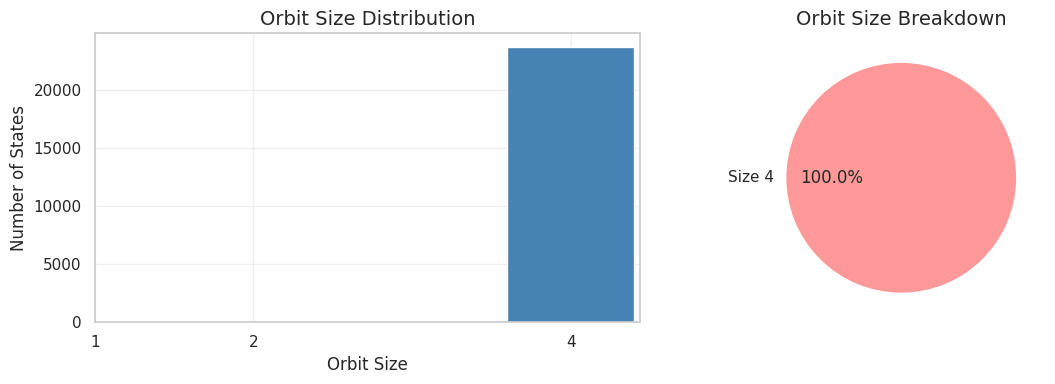

In [10]:
# Visualize orbit size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of orbit sizes
size_counts = pd.Series(sizes).value_counts().sort_index()
axes[0].bar(size_counts.index, size_counts.values, color='steelblue')
axes[0].set_xlabel('Orbit Size')
axes[0].set_ylabel('Number of States')
axes[0].set_title('Orbit Size Distribution')
axes[0].set_xticks([1, 2, 4])

# Pie chart of orbit size fractions
labels = [f'Size {s}' for s in size_counts.index]
axes[1].pie(size_counts.values, labels=labels, autopct='%1.1f%%', colors=['#ff9999', '#99ccff', '#99ff99'])
axes[1].set_title('Orbit Size Breakdown')

plt.tight_layout()
plt.savefig('../../results/figures/04a_orbit_size_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Compression Ratio

In [11]:
# Compute compression ratio
compression = symmetry.orbit_compression_ratio(clean_states)
print(f"Compression ratio: {compression:.3f}x")

# Count unique canonical forms
canonical, transforms = symmetry.canonical_form(clean_states)
n_canonical = len(np.unique(canonical))
print(f"States: {len(clean_states):,}")
print(f"Orbits (canonical forms): {n_canonical:,}")

Compression ratio: 1.010x
States: 23,711
Orbits (canonical forms): 23,468


In [12]:
# Compression by depth
depths = features.depth(clean_states)

compression_by_depth = []
for d in np.unique(depths):
    mask = depths == d
    if mask.sum() >= 100:  # Need enough samples
        d_states = clean_states[mask]
        d_compression = symmetry.orbit_compression_ratio(d_states)
        compression_by_depth.append({
            'depth': d,
            'n_states': mask.sum(),
            'compression': d_compression,
        })

compression_df = pd.DataFrame(compression_by_depth)
print("Compression ratio by depth:")
print(compression_df.to_string(index=False))

Compression ratio by depth:
 depth  n_states  compression
     4       259     1.040161
     8      8530     1.020823
    12     12587     1.004629
    16      2241     1.000446


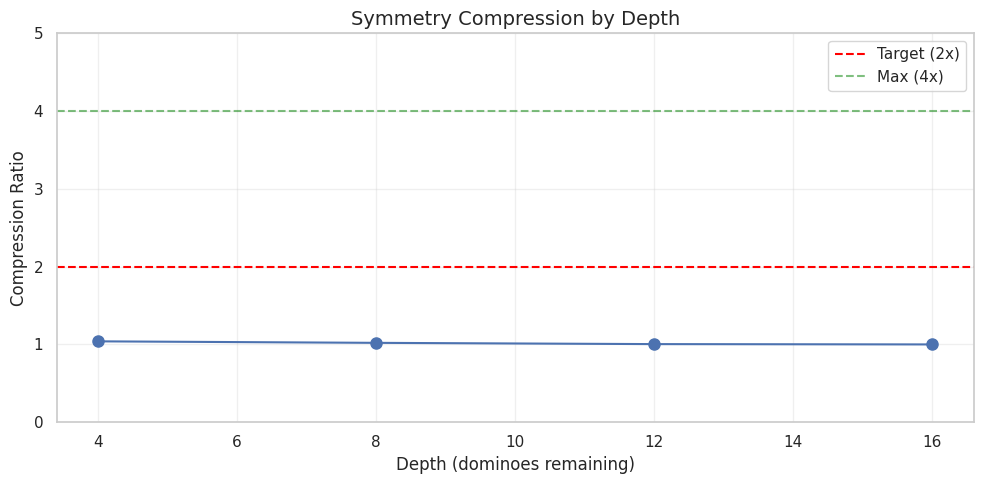

In [13]:
# Plot compression by depth
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(compression_df['depth'], compression_df['compression'], 'o-', markersize=8)
ax.axhline(y=2.0, color='red', linestyle='--', label='Target (2x)')
ax.axhline(y=4.0, color='green', linestyle='--', alpha=0.5, label='Max (4x)')
ax.set_xlabel('Depth (dominoes remaining)')
ax.set_ylabel('Compression Ratio')
ax.set_title('Symmetry Compression by Depth')
ax.legend()
ax.set_ylim(0, 5)

plt.tight_layout()
plt.savefig('../../results/figures/04a_compression_by_depth.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Transform Distribution

In [14]:
# What transforms are used to reach canonical form?
transform_names = ['Identity', 'Team Swap', 'Seat Rotate', 'Swap+Rotate']
transform_counts = pd.Series(transforms).value_counts().sort_index()

print("Transform distribution (to canonical form):")
for idx, count in transform_counts.items():
    print(f"  {transform_names[idx]}: {count:,} ({100*count/len(transforms):.1f}%)")

Transform distribution (to canonical form):
  Identity: 6,877 (29.0%)
  Team Swap: 6,565 (27.7%)
  Seat Rotate: 5,368 (22.6%)
  Swap+Rotate: 4,901 (20.7%)


## Summary

In [15]:
summary = {
    'Total states': f"{len(states):,}",
    'Clean states (trick_len=0)': f"{len(clean_states):,}",
    'Team swap V consistency': f"{100*swap_consistent/max(swap_total,1):.1f}%",
    'Seat rotate V consistency': f"{100*rotate_consistent/max(rotate_total,1):.1f}%",
    'Mean orbit size': f"{sizes.mean():.2f}",
    'Compression ratio': f"{compression:.3f}x",
    'Meets target (>2x)': 'YES' if compression > 2.0 else 'NO',
}

print(viz.create_summary_table(summary, "Exact Symmetries Summary"))

### Exact Symmetries Summary

| Metric | Value |
|--------|-------|
| Total states | 500,000 |
| Clean states (trick_len=0) | 23,711 |
| Team swap V consistency | 9.5% |
| Seat rotate V consistency | 10.9% |
| Mean orbit size | 4.00 |
| Compression ratio | 1.010x |
| Meets target (>2x) | NO |


In [16]:
# Save results
compression_df.to_csv('../../results/tables/04a_compression_by_depth.csv', index=False)
print("Results saved to results/tables/04a_compression_by_depth.csv")

Results saved to results/tables/04a_compression_by_depth.csv
